# Kaggle Toxic Comments Challenge

In [2]:
import pandas as pd
import numpy as np
import gensim
import keras
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

Using TensorFlow backend.


## Data Loading

In [3]:
df = pd.read_csv('data/train.csv',index_col='id')
df_test = pd.read_csv('data/test.csv', index_col = 'id')

In [4]:
df_test.isnull().sum()

comment_text    1
dtype: int64

In [5]:
df_test.fillna('', inplace = True)

In [6]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [5]:
df.shape

(95851, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95851 entries, 22256635 to 999988164717
Data columns (total 7 columns):
comment_text     95851 non-null object
toxic            95851 non-null int64
severe_toxic     95851 non-null int64
obscene          95851 non-null int64
threat           95851 non-null int64
insult           95851 non-null int64
identity_hate    95851 non-null int64
dtypes: int64(6), object(1)
memory usage: 5.9+ MB


## Preprocessing

In [9]:
simple_tokens = df.comment_text.apply(gensim.utils.simple_preprocess)

In [23]:
simple_tokens

id
22256635        [nonsense, kiss, off, geek, what, said, is, tr...
27450690        [please, do, not, vandalize, pages, as, you, d...
54037174        [points, of, interest, removed, the, points, o...
77493077        [asking, some, his, nationality, is, racial, o...
79357270        [the, reader, here, is, not, going, by, my, sa...
82428052         [fried, chickens, is, dat, sum, fried, chickens]
87311443        [why, can, you, put, english, for, example, on...
114749757       [guy, fawkes, im, resident, in, bridgwater, an...
138560519       [as, far, as, nicknames, go, this, article, is...
139353149       [woodland, meadows, good, to, hear, that, you,...
150009866       [well, just, finished, good, bit, of, editing,...
152276337       [discussion, should, take, place, on, the, art...
153331729       [uh, oh, you, called, my, bluff, am, intimidat...
153600803       [we, should, also, contact, the, living, desce...
154186883       [may, utc, notability, of, your, new, heart, t...
1618941

In [15]:
df[df.index==999898414104]['comment_text'] # this is the actual conversion : [it, staying, let, move, on, corbett]

id
999898414104    "\nIt's staying. Let's move on.  Corbett "
Name: comment_text, dtype: object

In [18]:
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)

In [21]:
tokenized_text = list(tokenizer[simple_tokens]) # a 2D list of all the keywords from comment_text

In [24]:
tokenized_text[0]

['nonsense',
 'kiss',
 'off',
 'geek',
 'what',
 'said',
 'is',
 'true',
 'll',
 'have',
 'your',
 'account',
 'terminated']

In [25]:
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)

In [27]:
TARGET_CLASSES = df.columns[1:]

In [28]:
TARGET_CLASSES

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [30]:
targets = df[TARGET_CLASSES].values

## Analysis using seaborn

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

(0, 400)

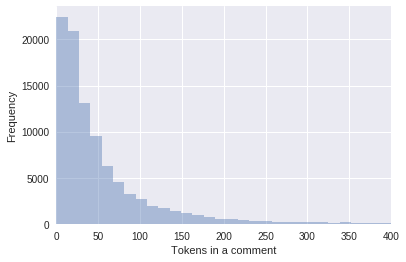

In [32]:
sns.distplot([len(doc) for doc in tokenized_text], bins=100, kde=False, label='Number of tokens per comment.')
plt.xlabel("Tokens in a comment")
plt.ylabel("Frequency")
plt.xlim((0, 400))

## Training word2vec on comment data

In [33]:
word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)

In [34]:
word2vec.wv.most_similar('popularity')

[('discovery', 0.8508877754211426),
 ('budget', 0.8357287049293518),
 ('performance', 0.8303341269493103),
 ('branch', 0.8284405469894409),
 ('competition', 0.8227114677429199),
 ('principal', 0.8156657218933105),
 ('tribe', 0.8135004639625549),
 ('affairs', 0.8095980882644653),
 ('embassy', 0.8091640472412109),
 ('monarchy', 0.8082635402679443)]

In [35]:
word2vec.wv.most_similar('idiot')

[('moron', 0.8577525615692139),
 ('dude', 0.8556913137435913),
 ('dumb', 0.8339439630508423),
 ('faggot', 0.8332662582397461),
 ('prick', 0.81940758228302),
 ('loser', 0.8111914396286011),
 ('dumbass', 0.7976804375648499),
 ('fucking', 0.7937028408050537),
 ('motherfucker', 0.7929295301437378),
 ('fuck_off', 0.7922778129577637)]

## word2vec-based based model.

In [36]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(word2vec.vector_size,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model.fit(features, targets, epochs=10, validation_split=0.1)

Train on 86265 samples, validate on 9586 samples
Epoch 1/10
86265/86265 [==============================] - 10s - loss: 0.1049 - acc: 0.9674 - val_loss: 0.0836 - val_acc: 0.9702

In [39]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model-baseline.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
# serialize model to JSON
model_json = model.to_json()
with open("model-baseline.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model-baseline.h5")
print("Saved model to disk")

Saved model to disk


## Sequential models

In [40]:
# Note: shifting indices by 1 as index 0 will be used for padding.
docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]

In [41]:
MAX_SEQ_LEN = 50
padded_docs = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

In [42]:
max_idx = max(c for d in docs for c in d)
max_idx

136735

In [43]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ # for the '0' padding word
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])

### CNN

In [45]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPool1D, Flatten, BatchNormalization

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(52, 5, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(128, 3, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid',
                kernel_regularizer=keras.regularizers.l2(0.02)))
model.compile(Adam(0.001), 'binary_crossentropy')

In [46]:
model.fit(padded_docs, targets, batch_size=512, epochs=20, validation_split=0.1)

Train on 86265 samples, validate on 9586 samples
Epoch 1/20
86265/86265 [==============================] - 133s - loss: 0.5653 - val_loss: 0.3098

In [48]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model-cnn.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
# serialize model to JSON
model_json = model.to_json()
with open("model-cnn.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("model-cnn.h5")
print("Saved model to disk")

Saved model to disk


## Submission

In [47]:
def comment_to_sequential_input(comment):
    tokens = tokenizer[gensim.utils.simple_preprocess(comment)]
    t_ids = [corpus_dict.token2id[t] + 1 for t in tokens if t in word2vec.wv.vocab and t in corpus_dict.token2id]
    return keras.preprocessing.sequence.pad_sequences([t_ids], maxlen=MAX_SEQ_LEN)[0]

In [49]:
test_input = [comment_to_sequential_input("You are a jerk you freakin indian.").reshape(1, -1)]
for target_class, score in zip(TARGET_CLASSES, model.predict(test_input)[0]):
    print("{}: {:.2f}%".format(target_class, score * 100))

toxic: 99.93%
severe_toxic: 9.97%
obscene: 89.96%
threat: 2.02%
insult: 82.76%
identity_hate: 9.46%


In [50]:
test_inputs = np.array([comment_to_sequential_input(doc) for doc in df_test.comment_text])

In [51]:
test_outputs = model.predict(test_inputs)

In [52]:
test_outputs[0]

array([ 0.0789036 ,  0.00617168,  0.01881345,  0.00449502,  0.02149433,
        0.00881813], dtype=float32)

In [53]:
output_df = df_test.reset_index()[['id']].copy()

In [54]:
for i, target_class in enumerate(TARGET_CLASSES):
    output_df[target_class] = test_outputs[:, i]

In [55]:
output_df[output_df.toxic > 0.5].sample(10, random_state=0).merge(df_test.reset_index(), on='id')

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,970795210363,0.997292,0.020285,0.811091,0.006286,0.588454,0.021558,first things first. you're a fucking weirdo vi...
1,160445573936,0.680250,0.005177,0.104825,0.002904,0.059663,0.004923,:Nice try. When are you going to provide any p...
2,351832393175,0.536854,0.014038,0.116943,0.006331,0.093422,0.010558,"""\nI have a low IQ, because I come from Easter..."
3,654215902316,0.635371,0.011294,0.098857,0.004592,0.074091,0.011511,Justin garcia \n\njustin is a awsome kid that ...
4,238771191154,0.886325,0.026841,0.233254,0.013289,0.252669,0.040706,wow dude... you're a real douche. wow.
5,486825599278,0.995695,0.048299,0.753739,0.009197,0.565907,0.037099,This is bullshit. I hate you all. 128.61.128.159
6,895629235610,0.928848,0.020815,0.284615,0.006741,0.209101,0.014945,Please stop raping little boys in the anus. Do...
7,45365949607,0.993167,0.052128,0.728390,0.013292,0.619307,0.058687,why? ==\nare you such a stupid bitch?\n\n==
8,654103653477,0.986770,0.039801,0.530670,0.012741,0.445994,0.036060,So what? Go away and stop harassing me. You're...
9,439043725463,0.989504,0.012254,0.314106,0.007367,0.521264,0.008229,"Bonjou,\nMwen administratè nan wikipedya ak wi..."


In [57]:
output_df.to_csv('cnn-pred.csv', index=False)